# 1. Input Signals

In [9]:
## Figure Dimensions
pass

In [10]:
import numpy as np
## Parameter Initialization

duration=5000 # duration in ms
dt=0.1 # simulation time step.
tau=50 # Filter time for the input.
tRef=5 # Refractory period for the spike trains.
nn=100 # Number of spiketrains we seek to create later.
spikebin=5 # Number of ms per PSTH bin.
Timevector= np.arange(0.1,duration+0.1,dt)
# A vector of time in ms, in steps of dt.
WhiteNoise=np.random.rand(len(Timevector))-0.5
# uniform white noise drawn from +/- 0.5 as long as the time vector.
FilteredWhiteNoise=WhiteNoise*0
print(FilteredWhiteNoise.shape)
# an empty vector which we will use to create the time-filtered input.
SpikeTrains=np.zeros((nn,len(Timevector)))
#A Matrix that will hold all spiketrains.
PloTrains=SpikeTrains
# This is just a plotting variable to oercome a screen resolution problem in matlab.
avetrain=0
# A counter to calculate the average firing rate.
tslt=0
# (== t(ime)s(ince)l(ast)(t)oggle (this serves as a Boolean for the sparsification of the input signal.
tsls=np.zeros((nn,1))
# (== t(ime)s(ince)l(ast)(s)pike (to keep track of the refractory period of each spike train)
BinnedSpikeTrains=np.zeros((int(duration/spikebin)))
# a vector to create a PSTH with binwidth “spikebin” from the spike trains.

## Making the time-filtered white noise signal:
for t in range(int(duration//dt)):
    FilteredWhiteNoise[t] = WhiteNoise[t] - (WhiteNoise[t] - FilteredWhiteNoise[t-1])*np.exp(-dt/tau)

## This routine changes the signal trace "FilteredWhiteNoise” by a ”exp(-dt/tau)” fraction of the difference between the signal and a random number.
FilteredWhiteNoise=FilteredWhiteNoise/max(FilteredWhiteNoise)
#Normalize to a maximum value of 1.

(50000,)


Text(0.5, 1.0, 'Time Filtered White Noise (FWN)')

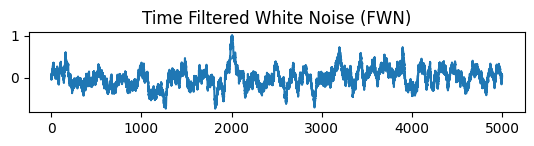

In [11]:
## Plotting
import matplotlib.pyplot as plt

plt.figure()
ax1 = plt.subplot(4,1,1)
ax1.plot(Timevector, FilteredWhiteNoise)
#ax1.set_xticks(list(range(0,duration)))
ax1.set_title('Time Filtered White Noise (FWN)')



In [12]:
## Normalize and Rectify
FilteredWhiteNoise=FilteredWhiteNoise*(500*dt/1000)
# Normalizes the trace to a peak value of 500Hz*dt (=0.05).
FilteredWhiteNoise[FilteredWhiteNoise<0]=0
# Sets all negative values of ”FilteredWhiteNoise” to 0.

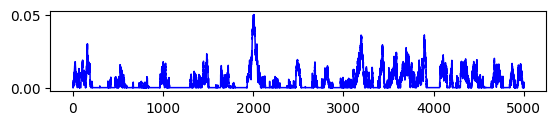

In [13]:
## Plotting:
ax2 = plt.subplot(4,1,2)
plt.plot(Timevector,FilteredWhiteNoise,linewidth=1.1, c='b' )
plt.show()

In [14]:
## Sparsifieing the Input Signals:
# This routine goes through the signal trace and deletes entire "activity bumps” if certain conditions are fullfilled:
toggle = 0
tslt=0
for d in range(int(duration/dt)-1):
# Routine becomes active (sets toggle == 1) if the signal is ==0, and the toggle is off (==0) and has been off for at least 1 ms:
    if FilteredWhiteNoise[d]==0 and toggle==0 and (d-tslt>10):
        toggle=1 # toggle set
        tslt=d # ”refractory” for toggle is set
# If routine active, every signal value is set to zero:
    if toggle==1:
        FilteredWhiteNoise[d] = 0
    # If routine has been active for longer than 0.5 ms, and the signal is 0, routine becomes inactive:
        if FilteredWhiteNoise[d+1]==0 and (d-tslt>5):
            toggle=0


Text(0.5, 1.0, 'Rectified & callibrated (blue) and sparsened (red) FWN')

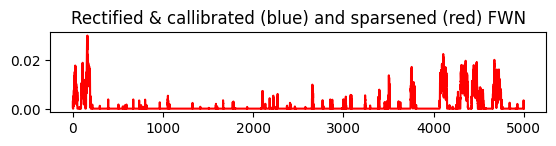

In [15]:
## Plotting:
ax3 = plt.subplot(4,1,2)
ax3.plot(Timevector, FilteredWhiteNoise, 'r')
#ax3.axis([0 duration -0.005 0.05])
ax3.set_title('Rectified & callibrated (blue) and sparsened (red) FWN')

In [16]:
## Adding background firing rate:
FilteredWhiteNoise=FilteredWhiteNoise+(5*dt/1000)
# This is adjusted so that without any FilteredWhiteNoise the firing rate is 5 Hz*dt (0.0005).

In [17]:
## Creating 100 spike trains:
for i in range(nn):
    for t in range(int(duration/dt)):
        if tsls[i] <= 0: # Allows potential spike if refractory period has subsided
            if np.random.rand()<FilteredWhiteNoise[t]:
                SpikeTrains[i,t] = 1#Fires if random variable < “FilteredWhiteNoise”.
                tsls[i] = tRef# Sets the absolute refractory period.
                avetrain=avetrain+1# Counts the total number of spikes.
                if duration/dt-t>25:# This is just a plotting routine.
                    PloTrains[i,t:t+25]=1#(Spike is elongated for plotting.)
        else:
            tsls[i]=tsls[i] -dt# subtracts dt from refractory counter if it is still >0.
    


avetrain=avetrain/(nn*duration/1000) #Calculates the average firing rate in Hz.

Text(0.5, 1.0, '100 Spiketrains')

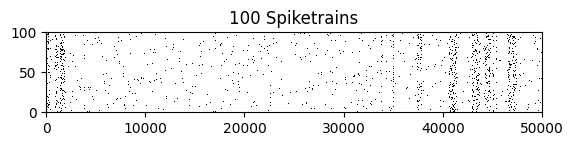

In [18]:
## Plotting:
ax4 = plt.subplot(4,1,3)
ax4.pcolor(-PloTrains,cmap='gray')
ax4.set_title('100 Spiketrains')

Text(0.5, 1.0, 'Average input rate for 1 excitatory channel, 0 Hz, peak 1 Hz')

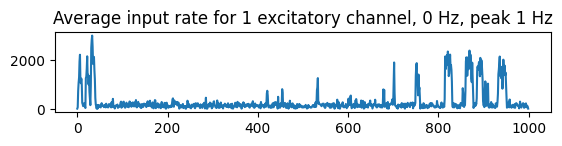

In [19]:
## Recording a PSTH / Binned Input rate:
# This bins the spikes into bins and calculates the instantaneous firing rate in Hz.
for i in range(int(duration/spikebin)-1):
    BinnedSpikeTrains[i]= sum(sum(SpikeTrains[:,((i-1)*(int(spikebin/dt)))+1:(i*(int(spikebin/dt)))]))

BinnedSpikeTrains= (BinnedSpikeTrains*(1000/spikebin))/nn

## Plotting:
ax5 = plt.subplot(4,1,4)
ax5.plot(BinnedSpikeTrains)
x=f'Average input rate for 1 excitatory channel, {0} Hz, peak {1} Hz'.format(avetrain, max(BinnedSpikeTrains))
ax5.set_title(x)

# 2. Single Cell Simulaions

In [20]:
## Parameters
eta=0.001
#Learning Rate
alpha=0.25*eta
#Decay term
tauPlasticity=20

#Time window of the learning rule.
duration=1500
#Duration of a single run in ms.
dt=0.1
# Simulation time step in ms.
NRuns=100
#Number of consecutive runs in one simulation.
#(The total duration of the simulation is thus “Duration*NRuns”.
tRef=5
# Refractory period for the spike trains.
gBarEx=0.014
# Scaling factor of the excitatory synaptic conductance in units of the leak (gleak = 10 nS)
gBarIn=0.035
# Scaling factor of the inhibitory synaptic conductance in units of the leak (gleak = 10 nS)
VRest=-60
#Resting potential in mV.
Vth=-50
# Threshold, in mV.
taumem=20
# Membrane time constant, in ms.
EAMPA=0
# Excitatory reversal potential, in mV.
EGABA=-80
# Inhibitory reversal potential, in mV.
tauEx=5
# Excitatory synaptic time constant, in ms.
tauIn=10
# Inhibitory synaptic time constant, in ms.
stopnow=0
# This is a flag to stop the while loop in case the EPSP routine below is uncommented

In [21]:
import math

## Input
noisetau=50
# Filter time for the input in ms
Backgroundrate=5*dt/1000
# Background spiking probability 5Hz*dt (= 0.0005) (see Technical Appendix 6.2.1).
ApproximateNormalizingFactor=0.03
# This serves to normalize the trace to an approximate peak value of 1
Maxrate=500*dt/1000
# Peak spiking probability 500Hz*dt (= 0.05))
NSigs=8
# Number of input signals.
NCells=1000
# Number of input spike trains.
ExFrac=0.8
#Fraction of Excitatory spike trains.
ExGroupsize=(NCells*ExFrac)/NSigs
# Number of spike trains in each excitatory input group

InGroupsize = math.ceil((NCells*(1-ExFrac))/NSigs)
# Number of spike trains in each inhibitory input group
# InGroupsize formula returns 24.999999999999993 in python but is 25 matlab
# migritation strategy = round up 

expGEx=np.exp(-dt/tauEx)
expGIn=np.exp(-dt/tauIn)
expPlasticity=np.exp(-dt/tauPlasticity)
expnoise=np.exp(-dt/noisetau)
# Pre-calculated exponential factors for speed of simulation

## Vectors
Input=np.zeros(NSigs)
# A vector that holds the momentary input signal for each signal channel
Timevector=np.arange(0.1,duration+0.1,dt)
# A vector of time in ms, in steps of dt.
Exkeep=Timevector*0
Inkeep=Timevector*0
# Vectors to keep the synaptic currents.
FilteredWhiteNoise=np.zeros(8)
# A vector to create the time-filtered input
InputGroup=np.zeros(NCells)
# A Vector that keeps track of which spike train belongs to which input
InputSpikeRefr=np.zeros(NCells)
# To keep track of the input spike train refractory periods)
tolos=0
# (== t(ime)o(f)l(ast)(o)utput (s)pike (Keeping track of the output cell's refractory period )
Synapse=np.ones(NCells)
#Synaptic weights
sgEx=np.zeros(NCells)
sgIn=np.zeros(NCells)
# Vectors to save the group-wise synaptic conductances the cell experiences.
AveExCurr=np.zeros(NSigs)
AveInCurr=np.zeros(NSigs)
# Vectors to save the group-wise synaptic currents the cell experiences.
pre=np.zeros(NCells)
# A Vector to save the presynaptic learning trace.
Time=np.arange(NRuns)
Rate=np.zeros(NRuns)
#Vectors for plotting

## InputGroups

# ii will be used as index
# i needs to be from 1 to 1000
# mitigation strategy = i = ii + 1

temptype=0
for ii in range(NCells):
    i = ii + 1
    if i<=NCells*ExFrac:
        if (i-1) % ExGroupsize == 0:
            temptype=temptype+1
        
        InputGroup[ii]= temptype
    else:
        if i % InGroupsize==0:
            temptype=temptype-1
        
        InputGroup[ii]= -temptype
    


InputGroup[999]=InputGroup[998]
# This routine assigns every spike train to an input group, starting with group 1 and ending
#with group NSIgs for the excitatory spike trains and then going back from NSigs to 1 for the
#inhibitory spiketrains. To label inhibitory spike trains uniquely, their group identity is assigned
#as a negative number.
## Synapse Tuning
for i in range(800):
    Synapse[i] = 0.3 + (1.1/(1+(InputGroup[i]-5)**4))+np.random.rand()*0.1

for i in range(801,NCells):
    Synapse[i] = 0.1

# This routine assigns a synaptic weight to every synapse. Excitatory synapses are tuned
#according to their group identity (plus a noise term) to resemble the tuning reported in (7).
#Inhibitory synapses are uniformly weak.

In [22]:
InputGroupTest = [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
        7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
        7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
        7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
        7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
        7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
        7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
        7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8., -8., -8., -8., -8., -8., -8.,
       -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8.,
       -8., -8., -8., -8., -8., -7., -7., -7., -7., -7., -7., -7., -7.,
       -7., -7., -7., -7., -7., -7., -7., -7., -7., -7., -7., -7., -7.,
       -7., -7., -7., -7., -6., -6., -6., -6., -6., -6., -6., -6., -6.,
       -6., -6., -6., -6., -6., -6., -6., -6., -6., -6., -6., -6., -6.,
       -6., -6., -6., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5.,
       -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5.,
       -5., -5., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
       -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,
       -4., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3.,
       -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]

if np.array_equal( InputGroup, InputGroupTest):
  print("InputGroup results are the same as in mathlab calculations")
else:
  raise BaseError("InputGroup results are not the same as in mathlab calculations")

InputGroup results are the same as in mathlab calculations


In [23]:
##################
## Simulation#####
##################
## Initialize values
gEx=0
# Overall excitatory synaptic conductance.
gIn=0
# Overall inhibitory synaptic cconductance.
gLeak=1
# Leak conductance (Everything else is normalized in respect to the leak.)
V = np.zeros(len(Timevector))
# we will need this when calculating the V at moment t
# this will allow us to set V[t]
V[0]=VRest
# Membrane potential is initially at VRest.
post=0
# Postsynaptic learning trace.
InputSpikeCount=0
OutputSpikeCount=0
AveCurrCounter=0
#Counters for rates and averaging.
tRunning=0
runcount=0
going=1
# Time parameters are initialized

## Start of the loops
while going>0:
    print(runcount)
    runcount=runcount+1
    # A counter to keep track of consecutive runs.
    OutputSpikeCount=0
    for i in range(NSigs):
        AveExCurr[i]=0
        AveInCurr[i]=0
    
    AveCurrCounter=0
    # Reset the counters.
    # #Uncomment from here to #XX to plot individual synapse strengths in [pS]
    # figure(2)
    # clf(2)
    # plot(gBarEx*Synapse(1:800)*10000, 'r.')
    # hold on
    # plot(-(-796:4:1),gBarIn*Synapse(801:NCells)*10000, 'g.')
    # ##XX end of commented section
    # Uncommenting this routine plots the synaptic weights in a second window.
    for t in np.arange(1,len(Timevector)):
        # The time loop begins here.
        tRunning=tRunning+dt
        gEx = gEx*expGEx
        gIn = gIn*expGIn
        for i in range(NSigs):
            sgEx[i] = sgEx[i]*expGEx
            sgIn[i] = sgIn[i]*expGIn
        
        # The synaptic conductances decay exponentially towards 0.
        for i in range(800,NCells):
            pre[i]= pre[i]*expPlasticity
        
        post=post*expPlasticity
        # The learning traces decay exponentially towards 0.
        ## Input Signals
        for i in range(NSigs):
            re=np.random.rand()-0.5
            FilteredWhiteNoise[i] = re -(re - FilteredWhiteNoise[i])*expnoise
            Input[i]=Backgroundrate + max(0, Maxrate*FilteredWhiteNoise[i])/ApproximateNormalizingFactor
        
        # At every time step the current input for each signal is calculated from a time-filtered
        # input signal. Signals traces are not saved to increase simulation speed.
        # For more details, please see 6.2.1

        # # # Uncomment from here to ###YY to plot single EPSPs at VRest
        # for i=1:NSigs
        # Input(i)=0
        # end
        # if(t==300/dt)
        # gEx = gEx + gBarEx
        # end
        # if(t==700/dt)
        # gIn = gIn + gBarIn
        # end
        # stopnow=1
        ######YY
        # Uncommenting this routine makes it possible to evaluate single EPSPs by switching off the
        #input signals and instead injecting one excitatory and one inhibitory PSP (at 300 and 700 ms)
        #into the cell. "stopnow” is a flag that stops the simulation after one run and rescales the axes
        #of the voltage plot.

        ## Presynaptic spike trains
        for i in range(NCells):

            # InputGroup values from -8 to 8
            # as a result, then the index of 8 is used, it has to be translated to 7
            # as the python the index starts with 0
            # and in mathlab - with 1
            InputGroupIndex = int(abs(InputGroup[i])) - 1

            if  np.random.rand() < Input[InputGroupIndex] and InputSpikeRefr[i]<=0:
                # If a Spiketrain fired a spike, (see also 6.2.1) ...
                if InputGroup[i]>0:
                    # .. and if it is excitatory...
                    gEx = gEx + (gBarEx * Synapse[i])
                    # ... increase the excitatory synaptic conductance variable according to
                    # the strength of the synapse
                    sgEx[InputGroupIndex]=sgEx[InputGroupIndex] + gBarEx*Synapse[i]
                    # (Keeping track of the synaptic conductances group-wise for plotting.)
                else:
                    # otherwise (meaning the synapse is inhibitory)...
                    gIn = gIn + gBarIn * Synapse[i]
                    # ... increase the synaptic conductance by the synapse strength
                    sgIn[InputGroupIndex]=sgIn[InputGroupIndex] + gBarIn*Synapse[i]
                    # (To keep track of the synaptic conductances group-wise for plotting.)
                    pre[i]= pre[i] + eta
                    # Update the presynaptic learning trace.
                    Synapse[i] =Synapse[i] + post - alpha
                    # Update the synaptic strength according to the rule.
                    # → add the effect of proximate post synaptic spikes, and subtract α.
                    if(Synapse[i] <=0):
                        Synapse[i]=0
                    
                    # Ensure non-negative synaptic weights.
                
                InputSpikeRefr[i]=tRef
                # ... Also: set the refractory time counter to the value of refractoriness
                InputSpikeCount=InputSpikeCount+1
                # .. and count the overall number of input spikes
            else:
                # meaning if no presynaptic spike was evoked:
                InputSpikeRefr[i]=InputSpikeRefr[i]-dt
                # subtract dt from the refractory counter.
            
        

        ## Membrane potential and postsynaptic spikes.
        if ((tRunning - tolos) < tRef):
            V[t] = VRest
            # If the Cell is refractory, keep V at Vrest
        else:
            # Meaning: if the cell is not refractory, ...
            gTot = gLeak + gEx + gIn
            # calculate the total membrane conductance,
            tauEff=taumem/gTot
            # and the effective time constant, as well as...
            VInf = ((gLeak*VRest + gEx * EAMPA+ gIn*EGABA)/gTot)
            # the membrane potential that V strives towards.
            V[t] = VInf + (V[t-1] - VInf)*np.exp(-dt/tauEff)
            # Use the above to update the membrane potential
            for i in range(NSigs):
                AveExCurr[i]= AveExCurr[i] + sgEx[i]*(V[t]-EAMPA)
                AveInCurr[i]= AveInCurr[i] + sgIn[i]*(V[t]-EGABA) + (gLeak*(V[t]-VRest))/NSigs
            
            AveCurrCounter=AveCurrCounter+1
            # The above routine keeps track for the group-wise input currents for plotting but
            # does not affect the behavior of the cell. We divide the (mostly inhibitory acting)
            # leak current evenly to all Groups,since each input signal causes the same absolute
            # amount of leak current (by deflecting the membrane potential away from rest with
            # identical statistics over time for each signal).
        
        if (V[t]>Vth):
            # If the membrane potential hits threshold...
            tolos=tRunning
            # ... set the refractory counter to the current time step
            V[t-1]=0
            # ... set the last membrane potential before the spike to zero (for plotting)
            V[t-1]=VRest
            # ... reset the current membrane potential to Vrest.
            OutputSpikeCount=OutputSpikeCount+1
            # ... count the spike.
            post = post + eta
            # ... update the postsynaptic learning trace
            for i in range(800,NCells):
                Synapse[i] = Synapse[i]+pre[i]
            
            # update all synapses according to the rule
            # → Add the effect of proximate presynaptic spikes.
        
        # subtract dt from the refractory counter.
        Exkeep[t]=gEx*(V[t]-EAMPA)
        Inkeep[t]=gIn*(V[t]-EGABA)
        # For plotting purposes, keeps track of the excitatory and inhibitory synaptic currents.
        # Because everything is normalized by the leak conductance, the values are saved in
        # units of 10nS × mV (= 10−11 Amp = [10pA]).
        # To plot in units of nA, one has to divide this number by 100.
    
    # End of the time loop
    Rate[runcount]=OutputSpikeCount/duration*1000
    Time[runcount]=runcount*duration/1000
    ##################
    # Plotting #######
    ##################
    fig = plt.figure((3,14))
    for i in [1,2,3 ,4 ,15 ,16 ,17 ,18]:
      fig, ax1 = plt.subplot(3,14,i)

    
    ax1.plot(Timevector, Exkeep/100,'k', 'LineWidth', 1)
    # plotting in units of nA hence the values need to be divided by 100, see above.
    
    ax1.plot(Timevector,Inkeep/100,c= [0.6 ,0.6, 0.6], linewidth= 1)
    ax1.plot(Timevector,(Inkeep+Exkeep)/100,c= [0, 0.6, 0])
    #axis([0 duration -3 3])
    ax1.set_ylabel('Synaptic Currents [nA]')

    for i in [29, 30 ,31 ,32]:
      fig, ax2 = plt.subplot(3,14,i)

    if (stopnow==0):
        fig, ax2.plot(Timevector, V, 'k')
    
    #axis([0 duration -65 5])
    ax2.set_ylabel('Mem. Pot. [mV]')
    ax2.set_xlabel('Time [ms]')
    
    for i in [6 ,7 ,8 ,9 ,20, 21 ,22 ,23 ,34 ,35 ,36 ,37]:
      fig, ax3 = plt.subplot(3,14,i )
    
    ax3.plot(list(range(8)), (-AveExCurr/AveCurrCounter)/100,'-ks',linewidth=2,\
        markeredgecolor='k',\
        markerfacecolor='k',\
        markersize=10)

    ax3.plot(list(range(8)), (AveInCurr/AveCurrCounter)/100,'-ks',linewidth=2,\
        markeredgecolor='k',\
        markerfacecolor='w',\
        markersize=10)
    #axis([1 8 0 0.25])
    ax3.set_ylabel('Mean Synaptic Currents [nA]')
    ax3.set_xlabel('Signal Number')
    
    for i in [11 ,12, 13, 14, 25, 26, 27, 28 ,39 ,40 ,41 ,42]:
      fig, ax4 = plt.subplot(3,14,i)
    ax4.plot(runcount*duration/1000, np.mean(Synapse[924:949])*gBarIn*10000, '.', c='r')
    # (Plotted in units of pS)
    ax4.plot(runcount*duration/1000, np.mean(Synapse[899:924])*gBarIn*10000, '.', c=[0.5, 0.0, 0.5])
    # (Plotted in units of pS)
    ax4.plot(runcount*duration/1000, np.mean(Synapse[874:899])*gBarIn*10000,  '.', c='b')
    # (Plotted in units of pS)
    ax4.set_ylabel('Mean Synaptic Strength [pS]')
    #axis([0 NRuns*duration/1000 0 800])
    

    '''
        ax1 = gca
    set(ax1,'XColor','k','YColor',[0.5 0.0 0.5], 'YAxisLocation','right')
    ax2 = axes('Position',get(ax1,'Position'),...
        'XAxisLocation','bottom',...
        'YAxisLocation','left',...
        'Color','none',...
        'XColor','k' ,'YColor','k')
    hold(ax2,'on')
    plot(Time(1:runcount), Rate(1:runcount), '.-k','Parent',ax2)
    ylabel('Mean Output Rate [Hz]','Parent',ax2)
    xlabel('Time [s]')
    axis([0 NRuns*duration/1000 0 100])
    '''


    if(runcount>NRuns):
        going=0
    
    if (stopnow==1):
        going=0
    
    # (This is only ==1 when the EPSP routine is uncommented)

# End of the while loop



C:\Users\Admin\AppData\Local\Temp\ipykernel_5548\2972142707.py:190: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


KeyboardInterrupt: 